In [1]:
from __future__ import division
import csv
import numpy as np
import pandas as pd
import math
from scipy.optimize import bisect
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pylab as pl
get_ipython().magic(u'matplotlib inline')

In [2]:
grid_data=pd.read_csv('results_GIS_SF_3.csv')
people_range=range(100,10600,500)
#select grid where pop_density>0
grid_data=grid_data[grid_data.pop_density_current != 0]

In [3]:
#import data
Electricity_EF_data = pd.read_csv('Electricity_EF_data.csv')
pipe_construction_data = pd.read_csv('pipe_construction_data.csv')
pipe_diameter_data = pd.read_csv('pipe_diameter_data2.csv')
pipe_maintenance_data = pd.read_csv('pipe_maintenance_data.csv')
pump_construction_data = pd.read_csv('pump_construction_data.csv')
slope_index_data = pd.read_csv('slope_index_data.csv')
steel_data = pd.read_csv('steel_data.csv')
transportation_data = pd.read_csv('transportation_data.csv')
treatment_data = pd.read_csv('treatment_data.csv')


#user set parameters
demand=0.2 #m3/person-day
total_demand_central = 241920 #m3/day
Electric_Utility="SFPUC"
Electric_Utility_pipes="2010 CA Power Mix"
pipe_material="PE"
miles_to_disposal=30
miles_transport=50
discount=0.04
lifetime_treatment=25
lifetime=50
#pop_density=500 #people/km2
street_density=8000 #m/km2
pump_operating_fraction=0.8
storage_days=3
tank_height=3
retention_time=6 #h
consumption_pressure=20 #m


Treatment_operational_energy_m3=2.4 #MJ/m3
Treatment_capital_energy_m3=0.5 #MJ/m3
Treatment_operational_GHG_m3=0.06  #kgCO2/m3
Treatment_operational_direct_GHG_m3 = 0.0005 #kgCO2/m3
Treatment_capital_GHG_m3= 0.07  #kgCO2/m3


#specify model parameters
electricity_cost=0.12 #$/kwh
specific_weight_water=9.807 #KN/m3
water_density=1000 #kg/m3
gravity=9.8 #m/s2
excavation_cost=4.6 #$/m3
excavation_energy=153 #MJ/m3
excavation_GHG=12 #kgCO2/m3
motor_efficiency=0.95
transport_cost=0.13 #$/ton-mile
transport_energy=8.16 #MJ/ton-mile
transport_GHG=0.656 #kgCo2/ton-mile
steel_cost=0.769 #$/kg
steel_GHG=1.3 #kgCO2/kg
steel_energy=17.5
steel_sheet_mass=186.9
steel_sheet_area=3.72
cement_energy=2820 #MJ/m3
cement_GHG=330 #kgCO2/m3
cement_cost=0.00005 #$/kg
reinf_concrete_energy=190 #Mj/m3
reinf_concrete_GHG=170 #kgCo2/m3
reinf_concrete_cost=115 # $/m3
reinf_concrete_density = 2400 #kg/m3
media_filtration_energy=0.05 #kWh/m3 (Opportunities and Economics of water reuse)
flocculation_energy=0.05 #kWh/m3 of tank volume (Lee,2010)

#specify treatment parameters
MBR_GHG=0.23
sludge_mass=0.1 #kg/m3 water treated
percent_fertilizer= 0.5 #percent of sludge disposed as fertilizer
percent_landfill= (1-percent_fertilizer) 
landfill_GHG=0.04
fertilizer_GHG=0
chlorine_energy=42 #MJ/kg
chlorine_GHG=0.74 #kg/kg
chlorine_mass=15 #mg/L
chlorine_retention_time=1 #h
Alum_density=120 #mg/L 
Alum_energy=0.91 #MJ/kg
Alum_GHG=0.07 #kgCO2/kg

RSF_rate=293 #m3/m2-day (Tchobanoglous small and decentralized)
RSF_sand_depth=0.6 #m (Tchobanoglous small and decentralized - deep bed sand) 

RSF_anthracite_depth=0.75
RSF_sand_density=1602 #kg/m3
RSF_sand_energy=0.147 #MJ/kg
RSF_sand_GHG=0.0104 #kgCO2/kg
RSF_anthracite_density=1100 #kg/m3
RSF_anthracite_energy=0.231 #MJ/kg
RSF_anthracite_GHG=0.06 #kgCO2/kg
flocculation_time=1 #hours
coagulation_time=0.3 #hours

Water_energy_intensity=1.12 #kWh/m3
Water_GHG_intensity=0.36 #kgCO2/m3

#Results
Scale_final=[]
grid_ID_final=[]

elevation_data_final=[]
pump_hp_final=[]
pipe_diameter_final=[]


Total_conveyance_capital_cost_final=[]
Total_conveyance_capital_GHG_final=[]
Total_conveyance_capital_energy_final=[]
Total_conveyance_operational_cost_final=[]
Total_conveyance_operational_GHG_final=[]
Total_conveyance_operational_energy_final=[]

Total_Treatment_Capital_cost_final=[]
Total_Treatment_Capital_energy_final=[]
Total_Treatment_Capital_GHG_final=[]
Total_Treatment_Operational_cost_final=[]
Total_Treatment_Operational_energy_final=[]
Total_Treatment_Operational_GHG_final=[]
Total_Treatment_energy_offsets=[]
Total_Treatment_GHG_offsets=[]

Total_Treatment_operational_energy_final=[]
Total_Treatment_capital_energy_final=[]
Total_Treatment_operational_GHG_final=[]
Total_Treatment_capital_GHG_final=[]

Total_Cost_final=[]
Total_Energy_final=[]
Total_GHG_final=[]


Pipe_capital_cost_final=[]
Pump_capital_cost_final=[]
Tank_capital_cost_final=[]
Pipe_capital_GHG_final=[]
Pump_capital_GHG_final=[]
Tank_capital_GHG_final=[]
Pipe_capital_energy_final=[]
Pipe_construction_energy_final=[]
Pipe_excavation_energy_final=[]
Pipe_transport_energy_final=[]
Pump_capital_energy_final=[]
Tank_capital_energy_final=[]
tank_const_energy_final=[]
tank_transport_energy_final=[]
pump_construction_energy_final=[]
pump_transport_energy_final=[]

Pipe_construction_GHG_final=[]
Pipe_excavation_GHG_final=[]
Pipe_transport_GHG_final=[]
Pump_capital_GHG_final=[]
Tank_capital_GHG_final=[]
tank_const_GHG_final=[]
tank_transport_GHG_final=[]
pump_construction_GHG_final=[]
pump_transport_GHG_final=[]

Pipe_operat_cost_final=[]
Pump_operat_cost_final=[]
Pipe_operat_GHG_final=[]
Pump_operat_GHG_final=[]
Pipe_operat_energy_final=[]
Pump_operat_energy_final=[]

MBR_Capital_energy_final=[]
MBR_Capital_GHG_final=[]
CoagFlocc_Capital_energy_final=[]
CoagFlocc_Capital_GHG_final=[]

MBR_Operational_energy_final=[]
MBR_Operational_GHG_final=[]
Chlorine_operational_energy_final=[]
Chlorine_operational_GHG_final=[]
RSF_Operational_energy_final=[]
RSF_Operational_GHG_final=[]

Sludge_transport_energy_final=[]
Sludge_transport_GHG_final=[]
Sludge_disposal_GHG_final=[]

Treatment_capital_energy_final=[]
Treatment_capital_GHG_final=[]
Treatment_operational_energy_final=[]
Treatment_operational_GHG_final=[]
Treatment_operational_direct_GHG_final=[]

RSF_capital_energy_final=[]
RSF_capital_GHG_final=[]

CoagFlocc_Capital_energy_final=[]
CoagFlocc_Capital_GHG_final=[]
CoagFlocc_Operational_energy_final=[]
CoagFlocc_Operational_GHG_final=[]
Chlorine_operational_energy_final=[]
Chlorine_operational_GHG_final=[]

Headloss_total=[]
Head_total=[]
Pressure_total=[]
dynamic_total=[]
Total_conveyance_operational_energy_collection=[]
Total_conveyance_operational_GHG_collection=[]
                


elevation_data=[]

In [17]:
slope_index_grid=grid_data['slope_index']
grid_index=grid_data['grid_ID']
length_centr=grid_data['length_m']
z_max=grid_data['Head_central_elevation']
pop_dens=grid_data['pop_density_current']
collection_energy=grid_data['collection_MJ_m3']
actual_length = grid_data['actual_length']
slp_index=slope_index_grid.tolist()
grd_index=grid_index.tolist()
z_max_rt=z_max.tolist()
length_cnt=length_centr.tolist()
pop_dens_index=pop_dens.tolist()
collection_energy_index=collection_energy.tolist()
actual_length_index=actual_length.tolist()
actual_length_index_new=[]
for item in actual_length_index:
    new = float(item)
    actual_length_index_new.append(new)

grid_slope_length=zip(grd_index,slp_index,length_cnt,z_max_rt,pop_dens_index,collection_energy_index,actual_length_index_new)


In [19]:
# ##Conveyance

#Iterate for each grid
for value in grid_slope_length:
    grid_ID=value[0]
    slope_index_grid=value[1]
    length_centralized_m=value[2]
    z_max_route=value[3]
    pop_density=value[4]
    collection_energy=value[5]
    length_centralized_const=value[6]
    
    #Calculate pipe length and elevation
    for i in people_range:
        people=i
        pipe_length_dec=people/pop_density*street_density
        if pipe_length_dec>street_density/2:
            pipe_length_dec=street_density/2
        if people>pop_density/2:
            elevation_dec=500*slope_index_grid
        else: 
            elevation_dec=math.sqrt(people/pop_density)*slope_index_grid*1000
        if elevation_dec==0:
            elevation_dec=0.1
        pipe_length=pipe_length_dec+length_centralized_m
        elevation=elevation_dec+z_max_route

        
        #Calculate pipe diameter
        total_dem=people*demand/(24) #m3/h
        if total_dem<1:
            total_dem=1
        else:
            total_dem=round(total_dem)

        pd_data = pipe_diameter_data
        k=pd_data.set_index('Flow_Rate_m3_h')
        pipe_diameter=k.PVC_Diameter_mm[total_dem]
        

        total_demand=people*demand/(24) #m3/h
        demand_day=total_demand*24
        pipe_area=math.pi*(pipe_diameter*0.001/2)**2
        pipe_velocity=total_dem/(3600*pipe_area)

        #normDiameterList = (40, 50, 63, 75, 90, 100, 125, 160, 200, 250, 300, 350, 400, 450, 500, 600) 
        normDiameterList = (50, 100, 160, 200, 350, 375, 450)
        index=normDiameterList.index(pipe_diameter)
        index=index+1
        pipe_diameter=normDiameterList[index]

        h1=0.03*pipe_length/((pipe_diameter)*0.001)*(pipe_velocity**2)/(2*9.81)
        threshold=0.30*(elevation)

        while h1>threshold:
            index=index+1
            pipe_diameter=normDiameterList[index]
            pipe_area_2=math.pi*(pipe_diameter*0.001/2)**2
            pipe_velocity=total_demand/(3600*pipe_area_2)
            h1=0.03*pipe_length/((pipe_diameter)*0.001)*(pipe_velocity**2)/(2*9.81)

        if pipe_velocity<=2.5:
            pipe_diameter=pipe_diameter
        else:
            index=index+1
            pipe_diameter=normDiameterList[index]

        pipe_area_2=math.pi*(pipe_diameter*0.001/2)**2
        pipe_velocity_2=total_demand/(3600*pipe_area_2)


        #Pipes
        #Piping construction
        pipe_construction_df=pipe_construction_data[(pipe_construction_data['Material'] == (pipe_material))]
        h=pipe_construction_df.set_index('size_mm')
        pipe_emissions_EF=h.Emissions_kgCO2_eq_m[pipe_diameter]
        pipe_energy_EF=h.Embodied_Energy_MJ_kg[pipe_diameter]
        pipe_cost_EF=h.cost_2012_m[pipe_diameter]
        pipe_weight=h.Wt_kg_m[pipe_diameter]
        pipe_excav_vol=h.Excavation_vol_m3_m[pipe_diameter]

        #Electricity GHG
        Electricity_GHG_df=Electricity_EF_data[(Electricity_EF_data['Name'] == (Electric_Utility))]
        Electricity_GHG_LCA=Electricity_GHG_df['EF_Lifecycle_kg_kWh'].iloc[0]
        Electricity_GHG_direct=Electricity_GHG_df['EF_Direct_kg_kWh'].iloc[0]
        
        Electricity_GHG_df_pipes=Electricity_EF_data[(Electricity_EF_data['Name'] == (Electric_Utility_pipes))]
        Electricity_GHG_LCA_pipes=Electricity_GHG_df['EF_Lifecycle_kg_kWh'].iloc[0]
        
        Pipe_const_cost=length_centralized_const*(pipe_cost_EF)/lifetime/(demand_day*365)
        Pipe_const_energy=(length_centralized_const*(pipe_energy_EF)*(pipe_weight))/lifetime/(demand_day*365)
        #Pipe_const_GHG=Pipe_const_energy/3.6*Electricity_GHG_LCA_pipes
        Pipe_const_GHG=pipe_emissions_EF*length_centralized_const/lifetime/(demand_day*365)

        
        #Piping excavation
        Pipe_mass=length_centralized_const*(pipe_weight)
        Pipe_excavation_vol=length_centralized_const*(pipe_excav_vol)
        Pipe_excavation_cost=Pipe_excavation_vol*(excavation_cost)/lifetime/(demand_day*365)
        Pipe_excavation_energy=Pipe_excavation_vol*(excavation_energy)/lifetime/(demand_day*365)
        Pipe_excavation_GHG=Pipe_excavation_vol*(excavation_GHG)/lifetime/(demand_day*365)

        #Piping transportation
        Pipe_transport_cost=transport_cost*miles_transport*Pipe_mass/(1000*lifetime)/(demand_day*365)
        Pipe_transport_energy=transport_energy*miles_transport*Pipe_mass/(1000*lifetime)/(demand_day*365)
        Pipe_transport_GHG=transport_GHG*miles_transport*Pipe_mass/(1000*lifetime)/(demand_day*365)


        #Piping maintenance
        pipe_maintenance_data['cost_discount_y'] = pipe_maintenance_data['cost_m']*pipe_length/((1+discount)**(pipe_maintenance_data['year_']-1))
        pipe_maintenance_data['energy_y'] = pipe_maintenance_data['KWh_m']*pipe_length*3.6
        pipe_maintenance_data['GHG_y'] = pipe_maintenance_data['energy_y']/3.6*Electricity_GHG_LCA_pipes

        pipe_maint_lifetime=pipe_maintenance_data[pipe_maintenance_data['year_'] <= lifetime]
        pipe_maint_cost=pipe_maint_lifetime['cost_discount_y'].sum()/lifetime/(demand_day*365)
        pipe_maint_GHG=pipe_maint_lifetime['GHG_y'].sum()/lifetime/(demand_day*365)
        pipe_maint_energy=pipe_maint_lifetime['energy_y'].sum()/lifetime/(demand_day*365)



        #Totals Pipes
        Pipe_capital_cost=(Pipe_const_cost+Pipe_excavation_cost+Pipe_transport_cost)
        Pipe_capital_energy=(Pipe_const_energy+Pipe_excavation_energy+Pipe_transport_energy)
        Pipe_capital_GHG=(Pipe_const_GHG+Pipe_excavation_GHG+Pipe_transport_GHG)

        Pipe_operat_cost=pipe_maint_cost
        Pipe_operat_energy=pipe_maint_energy
        Pipe_operat_GHG=pipe_maint_GHG


        #Calculate headloss
        headloss=0.03*pipe_length/((pipe_diameter)*0.001)*(pipe_velocity_2**2)/(2*9.81)


        #Calculate Pressure
        head=elevation-0
        pressure=((pipe_velocity_2**2)*water_density/2+(consumption_pressure/10*101325)+(head*gravity*water_density)+(headloss*gravity*water_density))
        total_head=pressure/(water_density*gravity)

        headloss_m=headloss
        head_m=head
        pressure_m=consumption_pressure
        dynamic_pressure=((pipe_velocity_2**2)/(2*gravity))
        
        
        
        #Calculate pump effieciency
        p_hp=(specific_weight_water*total_head*(total_demand/3600)/(0.4*motor_efficiency))*1.34
        if p_hp<3:
            pump_efficiency=0.4
        elif 3<=p_hp<7:
            pump_efficiency=0.45
        elif 7<=p_hp<15:
            pump_efficiency=0.5
        elif 15<=p_hp<40:
            pump_efficiency=0.55
        elif 40<=p_hp<60:
            pump_efficiency=0.6
        else:
            pump_efficiency=0.7
        p_hp=(specific_weight_water*total_head*(total_demand/3600)/(pump_efficiency*motor_efficiency))*1.34
        
        headloss_energy=specific_weight_water*headloss_m*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
        head_energy=specific_weight_water*head_m*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
        pressure_energy=specific_weight_water*pressure_m*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
        dynamic_energy=specific_weight_water*dynamic_pressure*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
      
    #Calculating actual pump horsepower
        Pump_energy_hp=p_hp*3.6*8765/1.34*pump_operating_fraction
        hp=round(((Pump_energy_hp/3.6)*1.34/8765),2)
        if hp<=0.5:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765)*2,1)/2
        elif 0.5<hp<10:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765),0)
        elif 10<=hp<100:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765)/10,0)*10
        else:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765)*2/1000,1)*1000/2
            
        if pump_hp<0.05:
            pump_hp=0.05

 

        #Pump Operation
        Pump_operat_energy=specific_weight_water*total_head*(total_demand/3600)*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)*3.6/(demand_day*365)
        Pump_operat_GHG=Pump_operat_energy/3.6*Electricity_GHG_LCA
        Pump_operat_cost=Pump_operat_energy/3.6*electricity_cost



        #Pump Construction
        t=pump_construction_data.set_index('Rating_hp')
        pump_cost_EF=t.Cost_2012[pump_hp]
        pump_energy_EF=t.Embodied_Energy_MJ[pump_hp]
        pump_GHG_EF=t.Emissions_kgCO_eq[pump_hp]
        pump_weight=t.Wt_kg[pump_hp]

        pump_construction_energy=pump_energy_EF/lifetime_treatment/(demand_day*365)
        pump_construction_GHG=pump_GHG_EF/lifetime_treatment/(demand_day*365)
        pump_construction_cost=pump_cost_EF/lifetime_treatment/(demand_day*365)

        pump_transport_cost=pump_weight*miles_transport*transport_cost/(1000*lifetime_treatment)/(demand_day*365)
        pump_transport_energy=pump_weight*miles_transport*transport_energy/(1000*lifetime_treatment)/(demand_day*365)
        pump_transport_GHG=pump_weight*miles_transport*transport_GHG/(1000*lifetime_treatment)/(demand_day*365)


        #Totals Pumps
        Pump_capital_cost=pump_construction_cost+pump_transport_cost
        Pump_capital_energy=pump_construction_energy+pump_transport_energy
        Pump_capital_GHG=pump_construction_GHG+pump_transport_GHG


        
        #Tanks
        tank_volume=storage_days*total_demand_central #m3
        tank_radius=math.sqrt(tank_volume/(math.pi*tank_height))
        tank_area=2*math.pi*tank_radius*tank_height+2*math.pi*tank_radius**2
        tank_cement_volume=0.1*tank_area
        tank_mass_steel=round(tank_area/steel_sheet_area,0)*steel_sheet_mass
        
        
        #tank construction
        tank_const_cost=tank_cement_volume*reinf_concrete_cost/lifetime/(total_demand_central*365)
        tank_const_energy=tank_cement_volume*reinf_concrete_energy/lifetime/(total_demand_central*365)
        tank_const_GHG=tank_cement_volume*reinf_concrete_GHG/lifetime/(total_demand_central*365)

        #tank transport
        tank_transport_cost=(tank_cement_volume*reinf_concrete_density)*transport_cost*miles_transport/(lifetime*1000)/(total_demand_central*365)
        tank_transport_energy=(tank_cement_volume*reinf_concrete_density)*transport_energy*miles_transport/(lifetime*1000)/(total_demand_central*365)
        tank_transport_GHG=(tank_cement_volume*reinf_concrete_density)*transport_GHG*miles_transport/(lifetime*1000)/(total_demand_central*365)



        #Tanks Totals
        Tank_capital_cost=tank_const_cost+tank_transport_cost
        Tank_capital_energy=tank_const_energy+tank_transport_energy
        Tank_capital_GHG=tank_const_GHG+tank_transport_GHG

        
        

        #Conveyance Totals
        
        Collection_pumping_energy=collection_energy #MJ/y
        Collection_pumping_GHG=Collection_pumping_energy/3.6*Electricity_GHG_LCA
        Total_conveyance_capital_cost_y=Pipe_capital_cost+Pump_capital_cost+Tank_capital_cost
        Total_conveyance_capital_GHG_y=Pipe_capital_GHG+Pump_capital_GHG+Tank_capital_GHG
        Total_conveyance_capital_energy_y=Pipe_capital_energy+Pump_capital_energy+Tank_capital_energy

        Total_conveyance_operational_cost_y=Pipe_operat_cost+Pump_operat_cost
        Total_conveyance_operational_GHG_y=Pipe_operat_GHG+Pump_operat_GHG
        Total_conveyance_operational_energy_y=Pipe_operat_energy+Pump_operat_energy
        
                
        ###Treatment
        
        #Total Centralized Treatment
        Central_treatment_operational_energy_y=Treatment_operational_energy_m3
        Central_treatment_capital_energy_y=Treatment_capital_energy_m3
        Treatment_operational_direct_GHG_y = Treatment_operational_direct_GHG_m3

        Central_treatment_operational_GHG_y=Treatment_operational_GHG_m3
        Central_treatment_capital_GHG_y=Treatment_capital_GHG_m3
        
        #Treatment for Recycling
        
        #Rapid Sand Filtration
        RSF_Area=total_demand_central/RSF_rate #m2
        RSF_sand_volume=RSF_Area*(RSF_sand_depth) #m3
        RSF_anthracite_volume=RSF_Area*(RSF_anthracite_depth) #m3
        RSF_volume=RSF_sand_volume+RSF_anthracite_volume
        RSF_surface_area=RSF_Area+8*RSF_volume/RSF_Area
        
        RSF_tank_mass_steel=round(RSF_surface_area/steel_sheet_area,0)*steel_sheet_mass
        RSF_sand_mass=RSF_sand_density*RSF_sand_volume
        RSF_anthracite_mass=RSF_anthracite_density*RSF_anthracite_volume

        # RSF tank construction
        RSF_tank_const_energy=RSF_tank_mass_steel*steel_energy/lifetime/(total_demand_central*365)
        RSF_tank_const_GHG=RSF_tank_mass_steel*steel_GHG/lifetime/(total_demand_central*365)

        # RSF_tank transport
        RSF_tank_transport_energy=RSF_tank_mass_steel*transport_energy*miles_transport/(lifetime*1000)/(total_demand_central*365)
        RSF_tank_transport_GHG=RSF_tank_mass_steel*transport_GHG*miles_transport/(lifetime*1000)/(total_demand_central*365)
        
        # RSF sand construction
        RSF_sand_const_energy=(RSF_sand_mass*RSF_sand_energy+RSF_anthracite_mass*RSF_anthracite_energy)/lifetime_treatment/(total_demand_central*365)
        RSF_sand_const_GHG=(RSF_sand_mass*RSF_sand_GHG+RSF_anthracite_mass*RSF_anthracite_GHG)/lifetime_treatment/(total_demand_central*365)

        # RSF_sand transport
        RSF_sand_transport_energy=(RSF_sand_mass+RSF_anthracite_mass)*transport_energy*miles_transport/(lifetime_treatment*1000)/(total_demand_central*365)
        RSF_sand_transport_GHG=(RSF_sand_mass+RSF_anthracite_mass)*transport_GHG*miles_transport/(lifetime_treatment*1000)/(total_demand_central*365)

        
        #Coagulation & Flocculation
        Coagulation_volume=total_demand_central/24*coagulation_time
        Coagulation_radius=math.sqrt(Coagulation_volume/(math.pi*1))
        Flocculation_volume=total_demand_central/24*flocculation_time
        Flocculation_radius=math.sqrt(Flocculation_volume/(math.pi*1))
        Coagu_Flocc_cement_volume=(((Coagulation_radius+0.1)**2-(Coagulation_radius)**2)*3.14)+((Flocculation_radius+0.1)**2-(Flocculation_radius)**2)*3.14
        Coag_Flocc_Capital_energy=Coagu_Flocc_cement_volume*reinf_concrete_energy/lifetime_treatment/(total_demand_central*365)
        
        
        
        #Alum addition
        Alum_mass=Alum_density*total_demand_central/1000*365
        Alum_manufacturing_energy=Alum_mass*Alum_energy/(total_demand_central*365)
        Alum_transport_energy=Alum_mass*transport_energy*miles_transport/1000/(total_demand_central*365)
        Alum_manufacturing_GHG=Alum_mass*Alum_GHG/(total_demand_central*365)
        Alum_transport_GHG=Alum_mass*transport_GHG*miles_transport/1000/(total_demand_central*365)
        Alum_operational_energy_y=Alum_manufacturing_energy+Alum_transport_energy
        Alum_operational_GHG_y=Alum_manufacturing_GHG+Alum_transport_GHG
        
        #Coagulation & Flocculation Totals
        CoagFlocc_Capital_energy_y=Coagu_Flocc_cement_volume*reinf_concrete_energy/lifetime_treatment/(total_demand_central*365)
        CoagFlocc_Capital_GHG_y=Coagu_Flocc_cement_volume*reinf_concrete_GHG/lifetime_treatment/(total_demand_central*365)
        
        CoagFlocc_Operational_energy_y=Alum_operational_energy_y+flocculation_energy
        CoagFlocc_Operational_GHG_y=(flocculation_energy)*Electricity_GHG_LCA+Alum_operational_GHG_y
        
                    
        #Chlorination
        chlorine_volume=chlorine_retention_time/24*total_demand_central
        chlorine_radius=math.sqrt(chlorine_volume/(math.pi*1))
        chlorine_cement_volume=((2*math.pi*chlorine_radius*1)+math.pi*chlorine_radius**2)*0.10
        
        Chlorine_manufacturing_energy_y=chlorine_mass*chlorine_energy/1000+chlorine_cement_volume*reinf_concrete_energy/lifetime_treatment/(total_demand_central*365)
        Chlorine_manufacturing_GHG_y=chlorine_mass*chlorine_GHG/1000+chlorine_cement_volume*reinf_concrete_GHG/lifetime_treatment/(total_demand_central*365)
        Chlorine_transport_energy_y=chlorine_mass*transport_energy*total_demand_central*365*miles_transport/1000000/(total_demand_central*365)
        Chlorine_transport_GHG_y=chlorine_mass*transport_GHG*total_demand_central*365*miles_transport/1000000/(total_demand_central*365)
        Chlorine_operational_energy_y=Chlorine_manufacturing_energy_y+Chlorine_transport_energy_y
        Chlorine_operational_GHG_y=Chlorine_manufacturing_GHG_y+Chlorine_transport_GHG_y
        
    
        #RSF Totals
        RSF_capital_energy_y=RSF_tank_const_energy+RSF_sand_const_energy+RSF_sand_transport_energy+RSF_tank_transport_energy
        RSF_capital_GHG_y=RSF_tank_const_GHG+RSF_sand_const_GHG+RSF_sand_transport_GHG+RSF_tank_transport_GHG

        #RSF operation
        RSF_operational_energy=media_filtration_energy*3.6
        RSF_operational_GHG=RSF_operational_energy/3.6*Electricity_GHG_LCA

        #Tanks Totals
        Tank_capital_cost=tank_const_cost+tank_transport_cost
        Tank_capital_energy=tank_const_energy+tank_transport_energy
        Tank_capital_GHG=tank_const_GHG+tank_transport_GHG
        
        #Sludge
        Sludge_transport_energy_y=sludge_mass*0.2*total_demand_central*365*miles_to_disposal*transport_energy/1000/(total_demand_central*365)
        Sludge_transport_GHG_y=sludge_mass*0.2*demand_day*365*miles_to_disposal*transport_GHG/1000/(demand_day*365)
        Sludge_disposal_GHG_y=landfill_GHG*sludge_mass*0.2*percent_landfill/(1000)+fertilizer_GHG*sludge_mass*0.2*percent_fertilizer/(1000)
                
        Total_Treatment_Capital_energy=Central_treatment_capital_energy_y+RSF_capital_energy_y+CoagFlocc_Capital_energy_y
        Total_Treatment_Operational_energy=Central_treatment_operational_energy_y+CoagFlocc_Operational_energy_y+RSF_operational_energy+Chlorine_operational_energy_y+Sludge_transport_energy_y
        Total_Treatment_Capital_GHG=Central_treatment_capital_GHG_y+RSF_capital_GHG_y+CoagFlocc_Capital_GHG_y
        Total_Treatment_Operational_GHG=Central_treatment_operational_GHG_y+CoagFlocc_Operational_GHG_y+RSF_operational_GHG+Chlorine_operational_GHG_y+Sludge_transport_GHG_y+Sludge_disposal_GHG_y
        
        #Treatment_energy_offsets_y=-(people*demand*365*Water_energy_intensity)
        #Treatment_GHG_offsets_y=-(people*demand*365*Water_GHG_intensity)
        Total_Energy_m3=Total_Treatment_Capital_energy+Total_Treatment_Operational_energy+Total_conveyance_operational_energy_y+Total_conveyance_capital_energy_y+Collection_pumping_energy
        Total_GHG_m3= Total_Treatment_Capital_GHG+Total_Treatment_Operational_GHG+Total_conveyance_operational_GHG_y+Total_conveyance_capital_GHG_y+Collection_pumping_GHG+Treatment_operational_direct_GHG_y

      
        #Results
        Scale_final.append(people)
        grid_ID_final.append(grid_ID)
        Total_conveyance_capital_cost_final.append(Total_conveyance_capital_cost_y)
        Total_conveyance_capital_GHG_final.append(Total_conveyance_capital_GHG_y)
        Total_conveyance_capital_energy_final.append(Total_conveyance_capital_energy_y)
        Total_conveyance_operational_cost_final.append(Total_conveyance_operational_cost_y)
        Total_conveyance_operational_GHG_final.append(Total_conveyance_operational_GHG_y)
        Total_conveyance_operational_energy_final.append(Total_conveyance_operational_energy_y)
        Total_conveyance_operational_energy_collection.append(Collection_pumping_energy)
        Total_conveyance_operational_GHG_collection.append(Collection_pumping_GHG)
        
        
        Headloss_total.append(headloss_energy)
        Head_total.append(head_energy)
        Pressure_total.append(pressure_energy)
        dynamic_total.append(dynamic_energy)
                
        
        Total_Treatment_operational_energy_final.append(Total_Treatment_Operational_energy)
        Total_Treatment_capital_energy_final.append(Total_Treatment_Capital_energy)
        Total_Treatment_operational_GHG_final.append(Total_Treatment_Operational_GHG)
        Total_Treatment_capital_GHG_final.append(Total_Treatment_Capital_GHG)
        Treatment_operational_direct_GHG_final.append(Treatment_operational_direct_GHG_y)


        Pipe_capital_cost_final.append(Pipe_capital_cost)
        Pump_capital_cost_final.append(Pump_capital_cost)
        Tank_capital_cost_final.append(Tank_capital_cost)
        Pipe_capital_GHG_final.append(Pipe_capital_GHG)
        Pump_capital_GHG_final.append(Pump_capital_GHG)
        Tank_capital_GHG_final.append(Tank_capital_GHG)
        Pipe_capital_energy_final.append(Pipe_capital_energy)
        Pump_capital_energy_final.append(Pump_capital_energy)
        Tank_capital_energy_final.append(Tank_capital_energy)

        Pipe_operat_cost_final.append(Pipe_operat_cost)
        Pump_operat_cost_final.append(Pump_operat_cost)
        Pipe_operat_GHG_final.append(Pipe_operat_GHG)
        Pump_operat_GHG_final.append(Pump_operat_GHG)
        Pipe_operat_energy_final.append(Pipe_operat_energy)
        Pump_operat_energy_final.append(Pump_operat_energy)
        
        Pipe_construction_energy_final.append(Pipe_const_energy)
        Pipe_excavation_energy_final.append(Pipe_excavation_energy)
        Pipe_transport_energy_final.append(Pipe_transport_energy)
        tank_const_energy_final.append(tank_const_energy)
        tank_transport_energy_final.append(tank_transport_energy)
        pump_construction_energy_final.append(pump_construction_energy)
        pump_transport_energy_final.append(pump_transport_energy)
        
        Pipe_construction_GHG_final.append(Pipe_const_GHG)
        Pipe_excavation_GHG_final.append(Pipe_excavation_GHG)
        Pipe_transport_GHG_final.append(Pipe_transport_GHG)
        tank_const_GHG_final.append(tank_const_GHG)
        tank_transport_GHG_final.append(tank_transport_GHG)
        pump_construction_GHG_final.append(pump_construction_GHG)
        pump_transport_GHG_final.append(pump_transport_GHG)
        
        Treatment_capital_energy_final.append(Central_treatment_capital_energy_y)
        Treatment_capital_GHG_final.append(Central_treatment_capital_GHG_y)
        Treatment_operational_energy_final.append(Central_treatment_operational_energy_y)
        Treatment_operational_GHG_final.append(Central_treatment_operational_GHG_y)
        
        RSF_capital_energy_final.append(RSF_capital_energy_y)
        RSF_capital_GHG_final.append(RSF_capital_GHG_y)
        RSF_Operational_energy_final.append(RSF_operational_energy)
        RSF_Operational_GHG_final.append(RSF_operational_GHG)
        CoagFlocc_Capital_energy_final.append(CoagFlocc_Capital_energy_y)
        CoagFlocc_Capital_GHG_final.append(CoagFlocc_Capital_GHG_y)
        CoagFlocc_Operational_energy_final.append(CoagFlocc_Operational_energy_y)
        CoagFlocc_Operational_GHG_final.append(CoagFlocc_Operational_GHG_y)
        Chlorine_operational_energy_final.append(Chlorine_operational_energy_y)
        Chlorine_operational_GHG_final.append(Chlorine_operational_GHG_y)
        Sludge_transport_energy_final.append(Sludge_transport_energy_y)
        Sludge_transport_GHG_final.append(Sludge_transport_GHG_y)
        Sludge_disposal_GHG_final.append(Sludge_disposal_GHG_y)
        

        elevation_data_final.append(elevation)
        pump_hp_final.append(pump_hp)
        pipe_diameter_final.append(pipe_diameter)
       
        
        
        Total_Energy_final.append(Total_Energy_m3)
        Total_GHG_final.append(Total_GHG_m3)



/Users/olga/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point


In [20]:
#total_energy DataFrame
label_pairs = zip(grid_ID_final,Scale_final,Total_conveyance_capital_energy_final,Total_conveyance_operational_energy_final,Total_Treatment_operational_energy_final,Total_Treatment_capital_energy_final,Total_conveyance_operational_energy_collection, Total_Energy_final)
total_energy=pd.DataFrame(label_pairs)
total_energy.columns = ['grid_ID','People', 'Total_conveyance_capital_energy_central_y','Total_conveyance_operational_energy_central_y','Total_Treatment_operational_energy_y','Total_Treatment_capital_energy_y','Total_conveyance_operational_energy_collection_y','Total_Energy_m3']
# total_energy['Scale']=(total_energy['People'])*0.2*365
# total_energy['Total_conveyance_capital_energy_central_m3']=(total_energy['Total_conveyance_capital_energy_central_y'])/(total_energy['Scale'])
# total_energy['Total_conveyance_operational_energy_central_m3']=(total_energy['Total_conveyance_operational_energy_central_y'])/(total_energy['Scale'])
# total_energy['Total_Treatment_operational_energy_m3']=(total_energy['Total_Treatment_operational_energy_y'])/(total_energy['Scale'])
# total_energy['Total_Treatment_capital_energy_m3']=(total_energy['Total_Treatment_capital_energy_y'])/(total_energy['Scale'])
# total_energy['Total_Energy_final_central_m3']=(total_energy['Total_Energy_final_central_y'])/(total_energy['Scale'])
# total_energy['Total_conveyance_operational_energy_collection_m3']=(total_energy['Total_conveyance_operational_energy_collection_y'])/(total_energy['Scale'])

In [21]:
#total_GHG DataFrame
label_pairs = zip(grid_ID_final,Scale_final,Total_conveyance_capital_GHG_final,Total_conveyance_operational_GHG_final,Total_Treatment_capital_GHG_final,Total_Treatment_operational_GHG_final,Treatment_operational_direct_GHG_final,Total_conveyance_operational_GHG_collection,Total_GHG_final)
total_GHG=pd.DataFrame(label_pairs)
total_GHG.columns = ['grid_ID','People', 'Total_conveyance_capital_GHG_central_y','Total_conveyance_operational_GHG_central_y','Total_Treatment_capital_GHG_y','Total_Treatment_operational_GHG_y', 'Treatment_operational_direct_GHG_y' ,'Total_conveyance_operational_GHG_collection_y','Total_GHG_m3']
# total_GHG['Scale']=(total_GHG['People'])*0.2*365
# total_GHG['Total_conveyance_capital_GHG_central_m3']=(total_GHG['Total_conveyance_capital_GHG_central_y'])/(total_GHG['Scale'])
# total_GHG['Total_conveyance_operational_GHG_central_m3']=(total_GHG['Total_conveyance_operational_GHG_central_y'])/(total_GHG['Scale'])
# total_GHG['Total_Treatment_operational_GHG_m3']=(total_GHG['Total_Treatment_operational_GHG_y'])/(total_GHG['Scale'])
# total_GHG['Total_Treatment_capital_GHG_m3']=(total_GHG['Total_Treatment_capital_GHG_y'])/(total_GHG['Scale'])
# total_GHG['Total_GHG_final_central_m3']=(total_GHG['Total_GHG_final_central_y'])/(total_GHG['Scale'])
# total_GHG['Total_conveyance_operational_GHG_collection_m3']=(total_GHG['Total_conveyance_operational_GHG_collection_y'])/(total_GHG['Scale'])

In [22]:
#energy by process DataFrame
label_pairs = zip(grid_ID_final,Scale_final,Pipe_capital_energy_final,Pump_capital_energy_final,Tank_capital_energy_final, Pipe_operat_energy_final, Pump_operat_energy_final,Pipe_construction_energy_final,Pipe_excavation_energy_final,Pipe_transport_energy_final,tank_const_energy_final,tank_transport_energy_final,pump_construction_energy_final,pump_transport_energy_final,Treatment_operational_energy_final,Treatment_capital_energy_final,RSF_capital_energy_final,RSF_Operational_energy_final,CoagFlocc_Capital_energy_final,CoagFlocc_Operational_energy_final,Chlorine_operational_energy_final,Sludge_transport_energy_final,Total_conveyance_operational_energy_collection)
process_energy = pd.DataFrame(label_pairs)
process_energy.columns = ['grid_ID','People', 'Pipe_capital_energy_final_y','Pump_capital_energy_final_y','Tank_capital_energy_final_y', 'Pipe_operat_energy_final_y', 'Pump_operat_energy_final_y','Pipe_construction_energy_final_y','Pipe_excavation_energy_final_y','Pipe_transport_energy_final_y','tank_const_energy_final_y','tank_transport_energy_final_y','pump_construction_energy_final_y','pump_transport_energy_final_y','Treatment_operational_energy_y','Treatment_capital_energy_y','RSF_capital_energy_y','RSF_operational_energy_y','CoagFlocc_Capital_energy_y','CoagFlocc_Operational_energy_y','Chlorine_operational_energy_y','Sludge_transport_energy_final_y','Total_conveyance_operational_energy_collection_y']
# process_energy['Scale']=(process_energy['People'])*0.2*365
# process_energy['Pipe_capital_energy_final_m3']=(process_energy['Pipe_capital_energy_final_y'])/(process_energy['Scale'])
# process_energy['Pump_capital_energy_final_m3']=(process_energy['Pump_capital_energy_final_y'])/(process_energy['Scale'])
# process_energy['Tank_capital_energy_final_m3']=(process_energy['Tank_capital_energy_final_y'])/(process_energy['Scale'])
# process_energy['Pipe_operat_energy_final_m3']=(process_energy['Pipe_operat_energy_final_y'])/(process_energy['Scale'])
# process_energy['Pump_operat_energy_final_m3']=(process_energy['Pump_operat_energy_final_y'])/(process_energy['Scale'])
# process_energy['Pipe_construction_energy_final_m3']=(process_energy['Pipe_construction_energy_final_y'])/(process_energy['Scale'])
# process_energy['Pipe_excavation_energy_final_m3']=(process_energy['Pipe_excavation_energy_final_y'])/(process_energy['Scale'])
# process_energy['Pipe_transport_energy_final_m3']=(process_energy['Pipe_transport_energy_final_y'])/(process_energy['Scale'])
# process_energy['tank_const_energy_final_m3']=(process_energy['tank_const_energy_final_y'])/(process_energy['Scale'])
# process_energy['tank_transport_energy_final_m3']=(process_energy['tank_transport_energy_final_y'])/(process_energy['Scale'])
# process_energy['pump_construction_energy_final_m3']=(process_energy['pump_construction_energy_final_y'])/(process_energy['Scale'])
# process_energy['pump_transport_energy_final_m3']=(process_energy['pump_transport_energy_final_y'])/(process_energy['Scale'])
# process_energy['Treatment_operational_energy_m3']=(process_energy['Treatment_operational_energy_y'])/(process_energy['Scale'])
# process_energy['Treatment_capital_energy_m3']=(process_energy['Treatment_capital_energy_y'])/(process_energy['Scale'])
# process_energy['RSF_capital_energy_m3']=(process_energy['RSF_capital_energy_y'])/(process_energy['Scale'])
# process_energy['RSF_operational_energy_m3']=(process_energy['RSF_operational_energy_y'])/(process_energy['Scale'])
# process_energy['CoagFlocc_Capital_energy_m3']=(process_energy['CoagFlocc_Capital_energy_y'])/(process_energy['Scale'])
# process_energy['CoagFlocc_Operational_energy_m3']=(process_energy['CoagFlocc_Operational_energy_y'])/(process_energy['Scale'])
# process_energy['Chlorine_operational_energy_m3']=(process_energy['Chlorine_operational_energy_y'])/(process_energy['Scale'])
# process_energy['Sludge_transport_energy_m3']=(process_energy['Sludge_transport_energy_final_y'])/(process_energy['Scale'])
# process_energy['Total_conveyance_operational_energy_collection_m3']=(process_energy['Total_conveyance_operational_energy_collection_y'])/(process_energy['Scale'])

In [23]:
#GHG by process DataFrame
label_pairs = zip(grid_ID_final,Scale_final,Pipe_capital_GHG_final,Pump_capital_GHG_final,Tank_capital_GHG_final, Pipe_operat_GHG_final, Pump_operat_GHG_final,Pipe_construction_GHG_final,Pipe_excavation_GHG_final,Pipe_transport_GHG_final,tank_const_GHG_final,tank_transport_GHG_final,pump_construction_GHG_final,pump_transport_GHG_final,Treatment_operational_GHG_final,Treatment_capital_GHG_final,RSF_capital_GHG_final,RSF_Operational_GHG_final,CoagFlocc_Capital_GHG_final,CoagFlocc_Operational_GHG_final,Chlorine_operational_GHG_final,Sludge_transport_GHG_final,Sludge_disposal_GHG_final,Treatment_operational_direct_GHG_final,Total_conveyance_operational_GHG_collection)
process_GHG = pd.DataFrame(label_pairs)
process_GHG.columns = ['grid_ID','People', 'Pipe_capital_GHG_final_y','Pump_capital_GHG_final_y','Tank_capital_GHG_final_y', 'Pipe_operat_GHG_final_y', 'Pump_operat_GHG_final_y','Pipe_construction_GHG_final_y','Pipe_excavation_GHG_final_y','Pipe_transport_GHG_final_y','tank_const_GHG_final_y','tank_transport_GHG_final_y','pump_construction_GHG_final_y','pump_transport_GHG_final_y','Treatment_operational_GHG_y','Treatment_capital_GHG_y','RSF_capital_GHG_y','RSF_operational_GHG_y','CoagFlocc_Capital_GHG_y','CoagFlocc_Operational_GHG_y','Chlorine_operational_GHG_y','Sludge_transport_GHG_y','Sludge_disposal_GHG_y','Treatment_operational_direct_GHG_y','Total_conveyance_operational_GHG_collection_y']
# process_GHG['Scale']=(process_GHG['People'])*0.2*365
# process_GHG['Pipe_capital_GHG_final_m3']=(process_GHG['Pipe_capital_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Pump_capital_GHG_final_m3']=(process_GHG['Pump_capital_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Tank_capital_GHG_final_m3']=(process_GHG['Tank_capital_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Pipe_operat_GHG_final_m3']=(process_GHG['Pipe_operat_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Pump_operat_GHG_final_m3']=(process_GHG['Pump_operat_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Pipe_construction_GHG_final_m3']=(process_GHG['Pipe_construction_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Pipe_excavation_GHG_final_m3']=(process_GHG['Pipe_excavation_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Pipe_transport_GHG_final_m3']=(process_GHG['Pipe_transport_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['tank_const_GHG_final_m3']=(process_GHG['tank_const_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['tank_transport_GHG_final_m3']=(process_GHG['tank_transport_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['pump_construction_GHG_final_m3']=(process_GHG['pump_construction_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['pump_transport_GHG_final_m3']=(process_GHG['pump_transport_GHG_final_y'])/(process_GHG['Scale'])
# process_GHG['Treatment_operational_GHG_m3']=(process_GHG['Treatment_operational_GHG_y'])/(process_GHG['Scale'])
# process_GHG['Treatment_capital_GHG_m3']=(process_GHG['Treatment_capital_GHG_y'])/(process_GHG['Scale'])
# process_GHG['RSF_capital_GHG_m3']=(process_GHG['RSF_capital_GHG_y'])/(process_GHG['Scale'])
# process_GHG['RSF_operational_GHG_m3']=(process_GHG['RSF_operational_GHG_y'])/(process_GHG['Scale'])
# process_GHG['CoagFlocc_Capital_GHG_m3']=(process_GHG['CoagFlocc_Capital_GHG_y'])/(process_GHG['Scale'])
# process_GHG['CoagFlocc_Operational_GHG_m3']=(process_GHG['CoagFlocc_Operational_GHG_y'])/(process_GHG['Scale'])
# process_GHG['Chlorine_operational_GHG_m3']=(process_GHG['Chlorine_operational_GHG_y'])/(process_GHG['Scale'])
# process_GHG['Sludge_transport_GHG_m3']=(process_GHG['Sludge_transport_GHG_y'])/(process_GHG['Scale'])
# process_GHG['Sludge_disposal_GHG_m3']=(process_GHG['Sludge_disposal_GHG_y'])/(process_GHG['Scale'])
# process_GHG['Total_conveyance_operational_GHG_collection_m3']=(process_GHG['Total_conveyance_operational_GHG_collection_y'])/(process_GHG['Scale'])

def calculate_unit(dataframe):
    dataframe['Scale']=(dataframe['People'])*0.2*365
    dataframe['Scale_central']=(total_demand_central)*365
    for column in dataframe:
        if (column == 'RSF_capital_GHG_y' or column == 'RSF_operational_GHG_y' or column == 'CoagFlocc_Capital_GHG_y' or column == 'CoagFlocc_Capital_GHG_y' or column == 'CoagFlocc_Operational_GHG_y' or column == 'Chlorine_operational_GHG_y' or column == 'Tank_capital_GHG_final_y' or column == 'tank_const_GHG_final_y' or column == 'tank_transport_GHG_final_y' or column == 'RSF_capital_energy_y' or column == 'RSF_operational_energy_y' or column == 'CoagFlocc_Capital_energy_y' or column == 'CoagFlocc_Capital_energy_y' or column == 'CoagFlocc_Operational_energy_y' or column == 'Chlorine_operational_energy_y' or column == 'Tank_capital_energy_final_y' or column == 'tank_const_energy_final_y' or column == 'tank_transport_energy_final_y' or column == 'Treatment_operational_direct_GHG_y'):
            column_new=column+"_m3"
            dataframe[column_new]=(dataframe[column])/(dataframe['Scale_central'])
        else:
            column_new=column+"_m3"
            dataframe[column_new]=(dataframe[column])/(dataframe['Scale'])
    return dataframe

def calculate_unit_totals(dataframe):
    dataframe['Scale']=(dataframe['People'])*0.2*365
    dataframe['Scale_central']=(total_demand_central)*365
    for column in dataframe:
        if (column == 'Total_Treatment_capital_GHG_y' or column == 'Total_Treatment_operational_GHG_y' or column == 'Total_Treatment_capital_energy_y' or column == 'Total_Treatment_operational_energy_y' or column == 'Treatment_operational_direct_GHG_y'):
            column_new=column+"_m3"
            dataframe[column_new]=dataframe[column]/dataframe['Scale_central']
        else:
            column_new=column+"_m3"
            dataframe[column_new]=dataframe[column]/dataframe['Scale']
    return dataframe

total_energy_m3=calculate_unit_totals(total_energy)
total_GHG_m3=calculate_unit_totals(total_GHG)
process_energy_m3=calculate_unit(process_energy)
process_GHG_m3=calculate_unit(process_GHG)

total_energy_m3['Total_Energy_m3'] = ((total_energy_m3['Total_Treatment_capital_energy_y_m3'])+(total_energy_m3['Total_Treatment_operational_energy_y_m3'])+(total_energy_m3['Total_conveyance_capital_energy_central_y_m3'])+(total_energy_m3['Total_conveyance_operational_energy_central_y_m3'])+(total_energy_m3['Total_conveyance_operational_energy_collection_y_m3']))
total_GHG_m3['Total_GHG_m3'] = ((total_GHG_m3['Total_Treatment_capital_GHG_y_m3'])+(total_GHG_m3['Total_Treatment_operational_GHG_y_m3'])+(total_GHG_m3['Total_conveyance_capital_GHG_central_y_m3'])+(total_GHG_m3['Total_conveyance_operational_GHG_central_y_m3'])+(total_GHG_m3['Total_conveyance_operational_GHG_collection_y_m3'])+(total_GHG_m3['Treatment_operational_direct_GHG_y_m3']))

In [24]:
label_pairs = zip(grid_ID_final,Scale_final,Headloss_total, Head_total, Pressure_total,dynamic_total,elevation_data_final)
test=range(len(Scale_final))
l_p_f=zip(test,label_pairs)
clusters = [[] for i in range(len(Scale_final))]
for pair in l_p_f:
    k= pair[0]
    position = pair[1]
    clusters[k].append(position)
p = [[] for i in range(len(Scale_final))]
frame=[]
cl=zip(test,clusters)
for row in cl:
    k1= row[0]
    clus= row[1]
    p[k1]=pd.DataFrame(clus)
    frame.append(p[k1])
process_pump = pd.concat(frame)
process_pump.columns = ['grid_ID','People','Headloss_total', 'Head_total', 'Pressure_total','dynamic_total','elevation']


In [25]:
pump_plot=process_pump[process_pump['grid_ID']==200]

In [26]:
process_pump_high=process_pump[(process_pump['grid_ID']==343)]
process_pump_low=process_pump[(process_pump['grid_ID']==175)]
#pump_plot.columns = ['Headloss_total', 'Head_total', 'Pressure_total','dynamic_total']
pump_plot_h=process_pump_high[['Headloss_total', 'Head_total', 'Pressure_total','dynamic_total']]
pump_plot_l=process_pump_low[['Headloss_total', 'Head_total', 'Pressure_total','dynamic_total']]

pump_plot_h.columns=['Headloss', 'Elevation head', 'Static head', 'Dynamic head']
pump_plot_l.columns=['Headloss', 'Elevation head', 'Static head', 'Dynamic head']

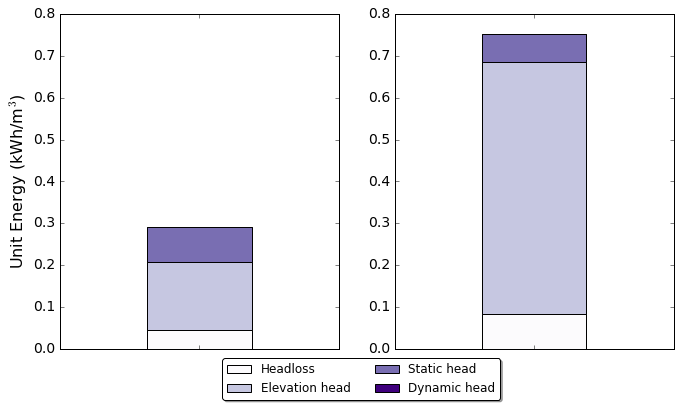

In [27]:
pump_plot_low=pump_plot_l[7:8]
pump_plot_high=pump_plot_h[7:8]
#pump_plot_high=pump_plot[(-1-1):-1]
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(121) # Create matplotlib axes
ax2 = fig.add_subplot(122)
pump_plot_low.index=[" "]
pump_plot_high.index=[" "]
a=pump_plot_low.plot(kind='bar', stacked=True,ax=ax,legend=False,colormap='Purples',fontsize=14, width=0.3)
a.set_ylim(0,0.8)
b=pump_plot_high.plot(kind='bar', stacked=True,ax=ax2,legend=False,colormap='Purples',fontsize=14, width=0.3)
#pump_plot_high.plot(kind='bar', stacked=True,figsize=(6,6),legend=True,colormap='summer',fontsize=14)
a.set_ylabel('Unit Energy (kWh/m$^3$)',fontsize=16)
plt.legend(bbox_to_anchor=(0.4, -0.01),ncol=2, fancybox=True, shadow=True)


process_energy_y=process_energy_m3[['grid_ID','People', 'Pipe_capital_energy_final_y','Pump_capital_energy_final_y','Tank_capital_energy_final_y', 'Pipe_operat_energy_final_y', 'Pump_operat_energy_final_y','Pipe_construction_energy_final_y','Pipe_excavation_energy_final_y','Pipe_transport_energy_final_y','tank_const_energy_final_y','tank_transport_energy_final_y','pump_construction_energy_final_y','pump_transport_energy_final_y','Treatment_operational_energy_y','Treatment_capital_energy_y','RSF_capital_energy_y','RSF_operational_energy_y','CoagFlocc_Capital_energy_y','CoagFlocc_Operational_energy_y','Chlorine_operational_energy_y','Sludge_transport_energy_final_y','Total_conveyance_operational_energy_collection_y']]
process_energy_m3=process_energy_m3[['grid_ID','People', 'Pipe_capital_energy_final_y_m3','Pump_capital_energy_final_y_m3','Tank_capital_energy_final_y_m3', 'Pipe_operat_energy_final_y_m3', 'Pump_operat_energy_final_y_m3','Pipe_construction_energy_final_y_m3','Pipe_excavation_energy_final_y_m3','Pipe_transport_energy_final_y_m3','tank_const_energy_final_y_m3','tank_transport_energy_final_y_m3','pump_construction_energy_final_y_m3','pump_transport_energy_final_y_m3','Treatment_operational_energy_y_m3','Treatment_capital_energy_y_m3','RSF_capital_energy_y_m3','RSF_operational_energy_y_m3','CoagFlocc_Capital_energy_y_m3','CoagFlocc_Operational_energy_y_m3','Chlorine_operational_energy_y_m3','Sludge_transport_energy_final_y_m3','Total_conveyance_operational_energy_collection_y_m3']]
process_GHG_y=process_GHG_m3[['grid_ID','People', 'Pipe_capital_GHG_final_y','Pump_capital_GHG_final_y','Tank_capital_GHG_final_y', 'Pipe_operat_GHG_final_y', 'Pump_operat_GHG_final_y','Pipe_construction_GHG_final_y','Pipe_excavation_GHG_final_y','Pipe_transport_GHG_final_y','tank_const_GHG_final_y','tank_transport_GHG_final_y','pump_construction_GHG_final_y','pump_transport_GHG_final_y','Treatment_operational_GHG_y','Treatment_capital_GHG_y','RSF_capital_GHG_y','RSF_operational_GHG_y','CoagFlocc_Capital_GHG_y','CoagFlocc_Operational_GHG_y','Chlorine_operational_GHG_y','Sludge_transport_GHG_y','Sludge_disposal_GHG_y','Treatment_operational_direct_GHG_y','Total_conveyance_operational_GHG_collection_y']]
process_GHG_m3=process_GHG_m3[['grid_ID','People', 'Pipe_capital_GHG_final_y_m3','Pump_capital_GHG_final_y_m3','Tank_capital_GHG_final_y_m3', 'Pipe_operat_GHG_final_y_m3', 'Pump_operat_GHG_final_y_m3','Pipe_construction_GHG_final_y_m3','Pipe_excavation_GHG_final_y_m3','Pipe_transport_GHG_final_y_m3','tank_const_GHG_final_y_m3','tank_transport_GHG_final_y_m3','pump_construction_GHG_final_y_m3','pump_transport_GHG_final_y_m3','Treatment_operational_GHG_y_m3','Treatment_capital_GHG_y_m3','RSF_capital_GHG_y_m3','RSF_operational_GHG_y_m3','CoagFlocc_Capital_GHG_y_m3','CoagFlocc_Operational_GHG_y_m3','Chlorine_operational_GHG_y_m3','Sludge_transport_GHG_y_m3','Sludge_disposal_GHG_y_m3','Treatment_operational_direct_GHG_y_m3','Total_conveyance_operational_GHG_collection_y_m3']]

In [28]:
total_energy_decentralized = pd.read_csv('total_energy_decentralized_m3.csv')
total_GHG_decentralized = pd.read_csv('total_GHG_decentralized_m3.csv')

In [29]:
#total_cost_decentralized_conveyance['Index']=total_cost_decentralized_conveyance.grid_ID.map(str)+" "+total_cost_decentralized_conveyance.People.map(str)
#total_cost['Index']=total_cost.grid_ID.map(str)+" "+total_cost.People.map(str)
#merged_cost = pd.merge(left=total_cost_decentralized_conveyance,right=total_cost, left_on='Index', right_on='Index')

total_energy_decentralized['Index']=total_energy_decentralized.grid_ID.map(str)+" "+total_energy_decentralized.People.map(str)
total_energy['Index']=total_energy.grid_ID.map(str)+" "+total_energy.People.map(str)
merged_energy = pd.merge(left=total_energy_decentralized,right=total_energy, left_on='Index', right_on='Index')

total_GHG_decentralized['Index']=total_GHG_decentralized.grid_ID.map(str)+" "+total_GHG_decentralized.People.map(str)
total_GHG['Index']=total_GHG.grid_ID.map(str)+" "+total_GHG.People.map(str)
merged_GHG = pd.merge(left=total_GHG_decentralized,right=total_GHG, left_on='Index', right_on='Index')

In [30]:
results2=merged_energy[(merged_energy['Total_Energy_final_y_m3'] < merged_energy['Total_Energy_m3'])][['grid_ID_x','People_x','Total_Energy_final_y_m3','Total_Energy_m3']]

In [31]:
results_GHG=merged_GHG[(merged_GHG['Total_GHG_final_y_m3'] < merged_GHG['Total_GHG_m3'])][['grid_ID_x','People_x','Total_GHG_final_y_m3','Total_GHG_m3']]

In [18]:
results2.to_csv('results_decentral_best.csv')

In [19]:
results_GHG.to_csv('results_decentral_best_ghg.csv')

diff=[]
grid_f=[]
peop_f=[]
for index,row in merged_energy.iterrows():
    if row[11]>row[23]:
        difference=row[11]-row[23]
        grid=row[0]
        peop=row[1]
        diff.append(difference)
        grid_f.append(grid)
        peop_f.append(peop)
        

diff_energy=zip(diff,grid_f,peop_f)
diff_energy_g=pd.DataFrame(diff_energy)

diff_energy_g.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\diff_energy_grid_centr.csv')

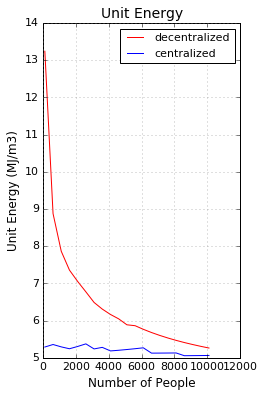

In [32]:
total_energy_decentralized_1=total_energy_decentralized[(total_energy_decentralized['grid_ID']==304)]
total_energy_1=total_energy[(total_energy['grid_ID']==304)]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,3,1)
plt.title('Unit Energy',fontsize=14)
a=plt.plot(total_energy_decentralized_1['People'],total_energy_decentralized_1['Total_Energy_final_y_m3'],'-r',label = 'decentralized')
b=plt.plot(total_energy_1['People'],total_energy_1['Total_Energy_m3'],'-b',label = 'centralized')
legend = plt.legend(frameon = 1, fontsize=11,loc='best')
plt.ylabel('Unit Energy (MJ/m3)',fontsize=12)
plt.xlabel('Number of People',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.yaxis.grid(color='gray', linestyle=':')
ax.xaxis.grid(color='gray', linestyle=':')

In [33]:
grouped_decentral_energy=total_energy_decentralized.groupby(total_energy_decentralized['grid_ID'])
grouped_central_energy=total_energy.groupby(total_energy['grid_ID'])
grouped_decentral_GHG=total_GHG_decentralized.groupby(total_GHG_decentralized['grid_ID'])
grouped_central_GHG=total_GHG.groupby(total_GHG['grid_ID'])

In [34]:
def group_in_cluster(dtframe1,field):
    grouped_decentral_energy=dtframe1.groupby(dtframe1[field])
    grid_ID_decentral=[[] for i in range(len(dtframe1))]
    for gr, item in grouped_decentral_energy:
        dt=item
        grid_ID_decentral[gr].append(dt)
    return grid_ID_decentral

In [35]:
grid_ID_decentral=group_in_cluster(total_energy_decentralized,'grid_ID')
grid_ID_central=group_in_cluster(total_energy,'grid_ID')
unique_grid_ID=total_energy_decentralized['grid_ID'].unique()
grid_ID_decentral_GHG=group_in_cluster(total_GHG_decentralized,'grid_ID')
grid_ID_central_GHG=group_in_cluster(total_GHG,'grid_ID')


In [41]:
grid_intersection=[]

for i in total_energy_decentralized['grid_ID'].unique():
    y1 = interp1d(grid_ID_decentral[i][0]['People'], grid_ID_decentral[i][0]['Total_Energy_final_y_m3'])
    y2 = interp1d(grid_ID_central[i][0]['People'], grid_ID_central[i][0]['Total_Energy_m3'])
    f = lambda x : y1(x) - y2(x)
    x1=100
    saving_decentral=(y2(10000) - y1(10000))
    saving_central=(y1(800) - y2(800))
    ysav_cen = y1(800)
    ysav_decen = y2(800)
            
    for x in reversed(range(100,10000,500)):
        #if 0<(y1(10000) - y2(10000))<0.25 or 0<(y2(10000) - y1(10000))<0.25:
            #x1=20000
            #break
            
        #if (y1(10000) - y2(10000))>0.25:
            #x1=10000 
            #y = y1(x1)
            #break
            
        if f(10000)*f(x)<0:
            x1 =bisect(f, x, 10000)
            y = y1(x1)
            break
            
          
        if (y2(x) - y1(x))>saving_decentral:
            saving_decentral=(y2(x) - y1(x))
            ysav_decen = y1(x)

 
                
    grid_intersection.extend([(i,x1,y,saving_decentral,ysav_decen,saving_central,ysav_cen)])

min_people=pd.DataFrame(grid_intersection)
min_people.columns=['grid_ID','People','Energy_MJ_m3','energy_savings','decentral_value','energy_savings_central','central_value']    


In [42]:
grid_intersection=[]

for i in total_GHG_decentralized['grid_ID'].unique():
    y1 = interp1d(grid_ID_decentral_GHG[i][0]['People'], grid_ID_decentral_GHG[i][0]['Total_GHG_final_y_m3'])
    y2 = interp1d(grid_ID_central_GHG[i][0]['People'], grid_ID_central_GHG[i][0]['Total_GHG_m3'])
    f = lambda x : y1(x) - y2(x)
    x1=100
    saving=(y2(10000) - y1(10000))
    saving_central=(y1(800) - y2(800))
    ysav_cen = y1(800)
        
    for x in reversed(range(100,10000,500)):
        #if 0<(y1(10000) - y2(10000))<0.000000001 or 0<(y2(10000) - y1(10000))<0.000000001:
            #x1=20000
            
            #break
            
        #if (y1(10000) - y2(10000))>0.01:
            #x1=10000
            #y=y1(x1)
            #break
            
        if f(10000)*f(x)<0:
            x1 =bisect(f, x, 10000)
            y = y1(x1)
            break
            
        if (y2(x) - y1(x))>saving:
            saving=(y2(x) - y1(x))
            ysav_decen = y1(x)
        
   
    grid_intersection.extend([(i,x1,y,saving,ysav_decen,saving_central,ysav_cen)])

min_people_GHG=pd.DataFrame(grid_intersection)
min_people_GHG.columns=['grid_ID','People','GHG_kg_m3','GHG_savings','decentral_value','GHG_savings_central','central_value']   

In [43]:
min_people.to_csv('min_people_energy.csv')
min_people_GHG.to_csv('min_people_GHG.csv')

In [44]:
process_energy_m3=process_energy[['grid_ID','People', 'Pipe_capital_energy_final_y','Pump_capital_energy_final_y','Tank_capital_energy_final_y', 'Pipe_operat_energy_final_y', 'Pump_operat_energy_final_y','Pipe_construction_energy_final_y','Pipe_excavation_energy_final_y','Pipe_transport_energy_final_y','tank_const_energy_final_y','tank_transport_energy_final_y','pump_construction_energy_final_y','pump_transport_energy_final_y','Treatment_operational_energy_y','Treatment_capital_energy_y','RSF_capital_energy_y','RSF_operational_energy_y','CoagFlocc_Capital_energy_y','CoagFlocc_Operational_energy_y','Chlorine_operational_energy_y','Sludge_transport_energy_final_y','Total_conveyance_operational_energy_collection_y']]
#process_energy_m3=process_energy[['grid_ID','People', 'Pipe_capital_energy_final_y_m3','Pump_capital_energy_final_y_m3','Tank_capital_energy_final_y_m3', 'Pipe_operat_energy_final_y_m3', 'Pump_operat_energy_final_y_m3','Pipe_construction_energy_final_y_m3','Pipe_excavation_energy_final_y_m3','Pipe_transport_energy_final_y_m3','tank_const_energy_final_y_m3','tank_transport_energy_final_y_m3','pump_construction_energy_final_y_m3','pump_transport_energy_final_y_m3','Treatment_operational_energy_y_m3','Treatment_capital_energy_y_m3','RSF_capital_energy_y_m3','RSF_operational_energy_y_m3','CoagFlocc_Capital_energy_y_m3','CoagFlocc_Operational_energy_y_m3','Chlorine_operational_energy_y_m3','Sludge_transport_energy_final_y_m3','Total_conveyance_operational_energy_collection_y_m3']]
process_GHG_m3=process_GHG[['grid_ID','People', 'Pipe_capital_GHG_final_y','Pump_capital_GHG_final_y','Tank_capital_GHG_final_y', 'Pipe_operat_GHG_final_y', 'Pump_operat_GHG_final_y','Pipe_construction_GHG_final_y','Pipe_excavation_GHG_final_y','Pipe_transport_GHG_final_y','tank_const_GHG_final_y','tank_transport_GHG_final_y','pump_construction_GHG_final_y','pump_transport_GHG_final_y','Treatment_operational_GHG_y','Treatment_capital_GHG_y','RSF_capital_GHG_y','RSF_operational_GHG_y','CoagFlocc_Capital_GHG_y','CoagFlocc_Operational_GHG_y','Chlorine_operational_GHG_y','Sludge_transport_GHG_y','Sludge_disposal_GHG_y','Treatment_operational_direct_GHG_y','Total_conveyance_operational_GHG_collection_y']]
#process_GHG_m3=process_GHG[['grid_ID','People', 'Pipe_capital_GHG_final_y_m3','Pump_capital_GHG_final_y_m3','Tank_capital_GHG_final_y_m3', 'Pipe_operat_GHG_final_y_m3', 'Pump_operat_GHG_final_y_m3','Pipe_construction_GHG_final_y_m3','Pipe_excavation_GHG_final_y_m3','Pipe_transport_GHG_final_y_m3','tank_const_GHG_final_y_m3','tank_transport_GHG_final_y_m3','pump_construction_GHG_final_y_m3','pump_transport_GHG_final_y_m3','Treatment_operational_GHG_y_m3','Treatment_capital_GHG_y_m3','RSF_capital_GHG_y_m3','RSF_operational_GHG_y_m3','CoagFlocc_Capital_GHG_y_m3','CoagFlocc_Operational_GHG_y_m3','Chlorine_operational_GHG_y_m3','Sludge_transport_GHG_y_m3','Sludge_disposal_GHG_y_m3','Total_conveyance_operational_GHG_collection_y_m3']]

In [45]:
total_energy_m3=total_energy[['grid_ID','People', 'Total_conveyance_capital_energy_central_y','Total_conveyance_operational_energy_central_y', 'Total_Treatment_capital_energy_y','Total_Treatment_operational_energy_y','Total_Energy_m3','Total_conveyance_operational_energy_collection_y']]
#total_energy_m3=total_energy[['grid_ID','People', 'Total_conveyance_capital_energy_central_y_m3','Total_conveyance_operational_energy_central_y_m3', 'Total_Treatment_operational_energy_y_m3','Total_Treatment_operational_energy_y_m3','Total_Energy_final_central_y_m3','Total_conveyance_operational_energy_collection_y_m3']]
total_GHG_m3=total_GHG[['grid_ID','People', 'Total_conveyance_capital_GHG_central_y','Total_conveyance_operational_GHG_central_y', 'Total_Treatment_capital_GHG_y','Total_Treatment_operational_GHG_y','Total_GHG_m3','Treatment_operational_direct_GHG_y','Total_conveyance_operational_GHG_collection_y']]
#total_GHG_m3=total_GHG[['grid_ID','People', 'Total_conveyance_capital_GHG_central_y_m3','Total_conveyance_operational_GHG_central_y_m3', 'Total_Treatment_capital_GHG_y_m3','Total_Treatment_operational_GHG_y_m3','Total_GHG_final_central_y_m3','Total_conveyance_operational_GHG_collection_y_m3']]

In [46]:
#total_energy_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\total_energy_centralized_y.csv')
total_energy_m3.to_csv('total_energy_centralized_m3.csv')
#total_GHG_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\total_GHG_centralized_y.csv')
total_GHG_m3.to_csv('total_GHG_centralized_m3.csv')
#process_energy_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\process_energy_centralized_y.csv')
process_energy_m3.to_csv('process_energy_centralized_m3.csv')
#process_GHG_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\process_GHG_centralized_y.csv')
process_GHG_m3.to_csv('process_GHG_centralized_m3.csv')